<a href="https://colab.research.google.com/github/CarloLonghi/SKAChallenge/blob/main/classification_pro_with_set2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from astropy.io import fits
from numpy.lib.function_base import _calculate_shapes
import pandas as pd
import os
import math
from matplotlib import pyplot as plt

Mount google drive and set the path where our data is stored. We can also use local files but they are slower to upload

In [2]:
from google.colab import drive
drive.mount('/content/drive')

dir_path = "drive/MyDrive/DL/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Get the fits file from the drive and extract the image

In [3]:
fits_img = fits.open(dir_path + "SKAMid_B2_8h_v3.fits")
print(fits_img.info())
fits_img = fits_img[0].data[0,0,:,:]
fits_img = fits_img[16350:,16350:]

Filename: drive/MyDrive/DL/SKAMid_B2_8h_v3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     113   (32768, 32768, 1, 1)   float32   
None


Parameter settings:
since when using the entire image the RAM of the system fills easily, we can 

*   since, when using the entire image the RAM of the system fills easily, we can use the image_size variable to work only on a portion of the image
*   cutout_size is the size of the squares in which the image is divided


In [4]:
cutout_size = 256
#image_size = 32700
image_size = 13080
#image_size = 4360
cutouts_per_row = image_size//cutout_size

Divide the image

In [5]:
cutouts = np.empty((cutouts_per_row**2,cutout_size,cutout_size, 1))

for i in range(0,cutouts_per_row):
  for j in range(0,cutouts_per_row):
    cutouts[i*cutouts_per_row+j,:,:,0] = fits_img[i*cutout_size:i*cutout_size+cutout_size,j*cutout_size:j*cutout_size+cutout_size]

del fits_img

In [6]:
for i in range(len(cutouts)):
  f = cutouts[i].flatten()
  avg = np.mean(f)
  std = np.std(f)
  cutouts[i] = (cutouts[i] - avg) / std

Upload the already filtered training set from the drive

In [7]:
FilteredTrainingSet=pd.read_csv(dir_path + "filtered_training_set_2.csv",)
#FilteredTrainingSet=pd.read_csv(dir_path + "TrainingSet_B1_v2.txt",skiprows=17,delimiter='\s+')
FilteredTrainingSet=FilteredTrainingSet[FilteredTrainingSet.columns[0:15]]
FilteredTrainingSet.columns=['ID','RA (core)','DEC (core)','RA (centroid)','DEC (centroid)','FLUX','Core frac','BMAJ','BMIN','PA','SIZE','CLASS','SELECTION','x','y']
FilteredTrainingSet['x']=FilteredTrainingSet['x'].astype(int)
FilteredTrainingSet['y']=FilteredTrainingSet['y'].astype(int)
FilteredTrainingSet['x']=FilteredTrainingSet['x']-16350
FilteredTrainingSet['y']=FilteredTrainingSet['y']-16350
FilteredTrainingSet = FilteredTrainingSet.set_index('ID')
print(np.min(FilteredTrainingSet['y']),np.max(FilteredTrainingSet['y']),np.min(FilteredTrainingSet['x']),np.max(FilteredTrainingSet['x']))

925 4104 34 3508


Generate images from the training set where each dot corresponds to a source

In [8]:
data=np.zeros((image_size,image_size,3), dtype=np.uint8 )
for i in range(0,len(FilteredTrainingSet)):
  x = int(FilteredTrainingSet['x'].iloc[i])
  y = int(FilteredTrainingSet['y'].iloc[i])
  c = int(FilteredTrainingSet['CLASS'].iloc[i]) - 1
  data[y,x,c] = 1

Divide the data generated images

In [9]:
data_array = np.empty((cutouts_per_row**2,cutout_size,cutout_size,3))

for i in range(0,cutouts_per_row):
  for j in range(0,cutouts_per_row):
    data_array[i*cutouts_per_row+j] = data[i*cutout_size:i*cutout_size+cutout_size,j*cutout_size:j*cutout_size+cutout_size]

del data

In [10]:
data_array[0].shape

(256, 256, 3)

In [11]:
cutouts[0].shape

(256, 256, 1)

In [12]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, BatchNormalization, MaxPool2D, Flatten, AvgPool2D, UpSampling2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import regularizers, layers
from tensorflow.data import Dataset

In [13]:
train_x, test_x, train_y, test_y = train_test_split(cutouts, data_array, test_size=0.25, random_state=42,shuffle=True)
del data_array
del cutouts
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.25, random_state=42,shuffle=True)



In [14]:
print(np.shape(val_y))

(488, 256, 256, 3)


Define Augmentation layers


In [15]:
IMG_SIZE = 128

resize_rescale_flip_rotate = Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255),
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

Define the model

> Indented block



In [16]:
input_layer = Input(shape=(cutout_size, cutout_size, 1))
x = resize_rescale_flip_rotate(input_layer)
x = Conv2D(32, (5, 5), strides=1, activation='relu', padding='same', name='conv1')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(0.50)(x)
x = Conv2D(32, (5, 5), strides=1, activation='relu', padding='same', name='conv2')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)
#x = Dropout(0.50)(x)
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='conv3')(x)
x = BatchNormalization()(x)
#x = MaxPool2D(pool_size=(2,2))(x)
#x = Flatten()(x)
#x = Reshape((128,128,64))(x)
#x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same', name='conv3')(x)
x = UpSampling2D(size=(8,8))(x)
#x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same', name='conv4')(x)
#x = UpSampling2D(size=(2,2))(x)
x = Dense(64, activation='relu', name='dense1')(x)
x = Dropout(0.20)(x)
x = Dense(32, activation='relu', name='dense2')(x)
x = Dropout(0.3)(x)
output_layer = Dense(3,activation='softmax', name='dense3')(x)
#output_layer = Conv2D(3,(1,1),strides=1 ,activation='relu', padding = 'same')(x)

myCNN = Model(input_layer,output_layer)
adadelta = optimizers.Adadelta(learning_rate=0.002, decay=0.0, rho=0.99)
nadam = optimizers.Nadam(learning_rate=0.0001)
myCNN.compile(optimizer=adadelta, loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
cp = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

print(myCNN.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 32)      832       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 32)        25632 

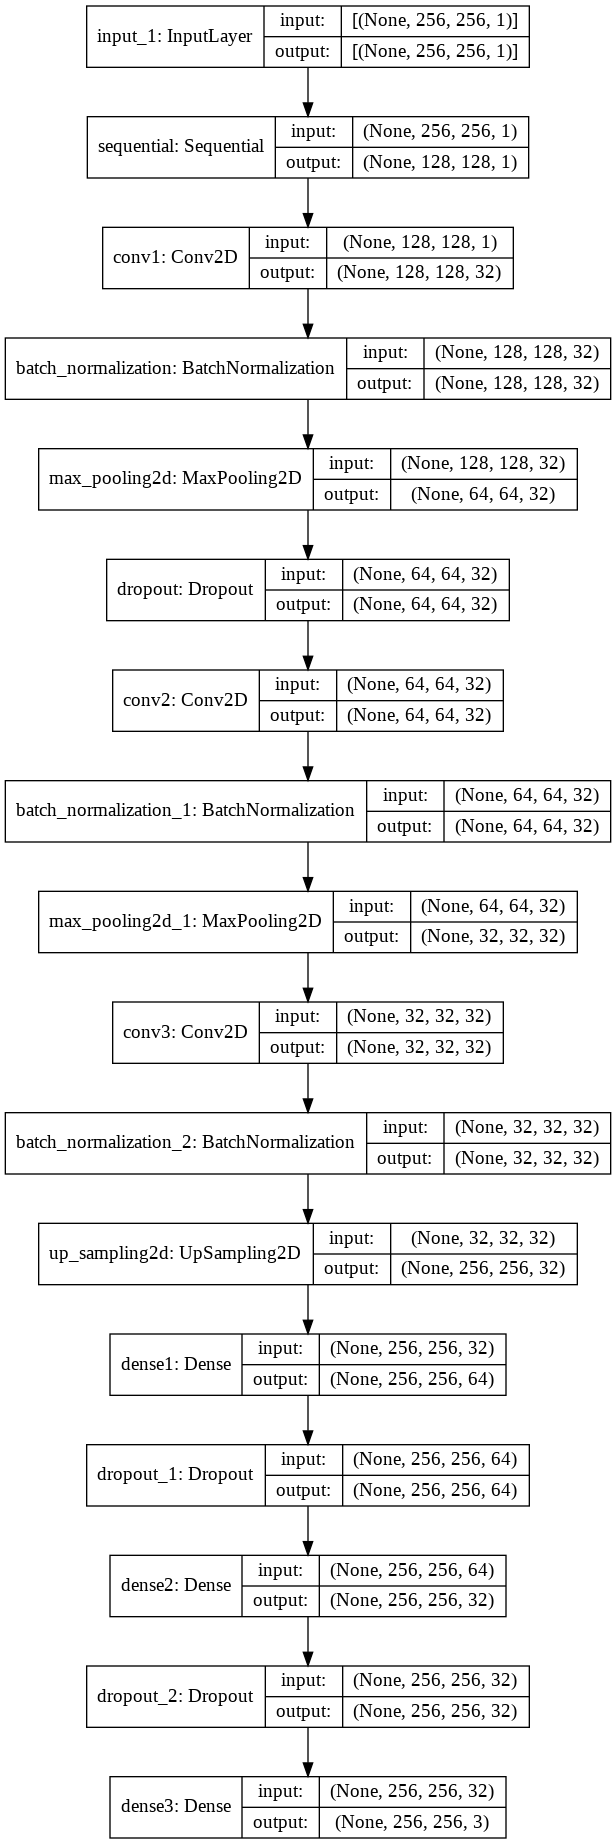

In [17]:
from tensorflow.keras.utils import plot_model

plot_model(myCNN,show_shapes=True)

Training of our model

In [18]:
batch_size = 32

In [19]:
print(np.shape(val_y))

(488, 256, 256, 3)


In [20]:
base_history = myCNN.fit(train_x, train_y, epochs=10, batch_size=batch_size, shuffle=True, validation_data=(val_x, val_y), verbose=1, callbacks=[es, cp])

Epoch 1/10
46/46 [==============================] - 269s 6s/step - loss: 1.9060e-05 - accuracy: 0.7389 - val_loss: 1.3695e-05 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.00001, saving model to best_model.hdf5
Epoch 2/10
46/46 [==============================] - 270s 6s/step - loss: 1.8414e-05 - accuracy: 0.7386 - val_loss: 1.3911e-05 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00001
Epoch 3/10
46/46 [==============================] - 271s 6s/step - loss: 1.9723e-05 - accuracy: 0.7381 - val_loss: 1.4045e-05 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00001
Epoch 4/10
46/46 [==============================] - 270s 6s/step - loss: 1.8367e-05 - accuracy: 0.7369 - val_loss: 1.4112e-05 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00001
Epoch 00004: early stopping


In [21]:
myCNN.save('base_model.h5')

In [22]:
results = myCNN.evaluate(test_x, test_y, batch_size=batch_size,verbose=0)
print('Loss: {:.6f} Accuracy: {:.3f}'.format(results[0],results[1]))

Loss: 0.000 Accuracy: 1.000


In [23]:
print(base_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [24]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

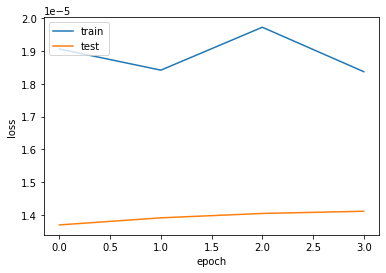

In [25]:
plot_history(base_history,['loss','val_loss'])

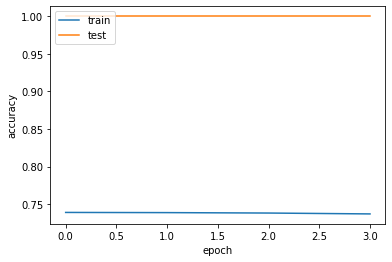

In [26]:
plot_history(base_history,['accuracy','val_accuracy'])

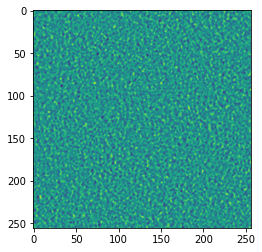

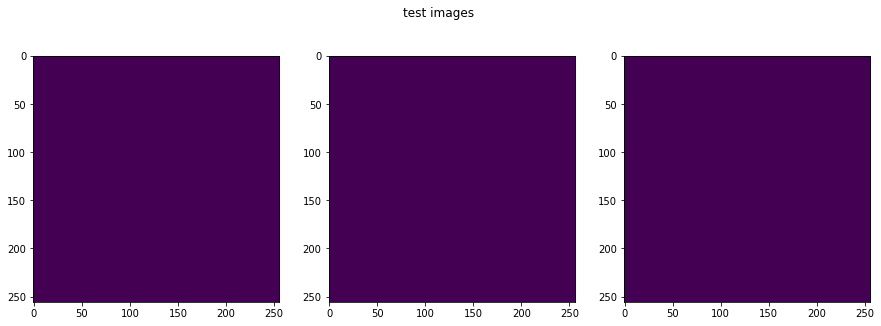

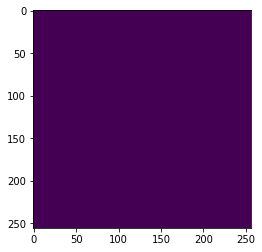

In [27]:
n = 3

plt.imshow(test_x[n][:,:,0])
plt.show()

fig = plt.figure(figsize=(15,5))
fig.suptitle('test images')
fig.add_subplot(1,3,1)
plt.imshow(test_y[n][:,:,0])
fig.add_subplot(1,3,2)
plt.imshow(test_y[n][:,:,1])
fig.add_subplot(1,3,3)
plt.imshow(test_y[n][:,:,2])
plt.show()

a = test_y[n][:,:,0]+test_y[n][:,:,1]+test_y[n][:,:,2]
plt.imshow(a)
plt.show()

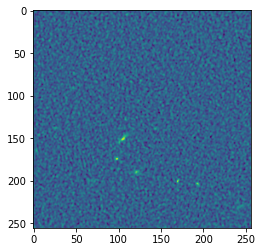

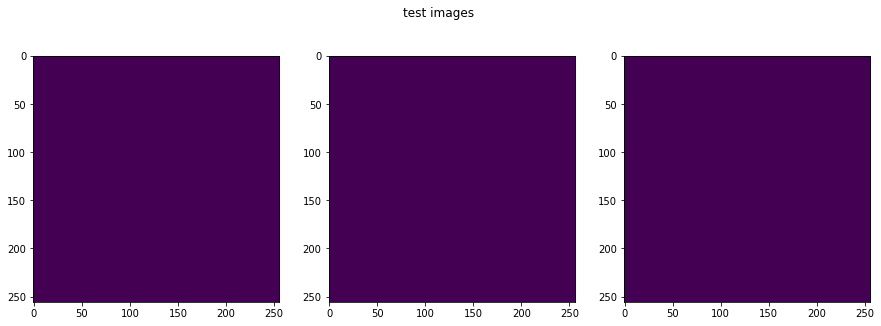

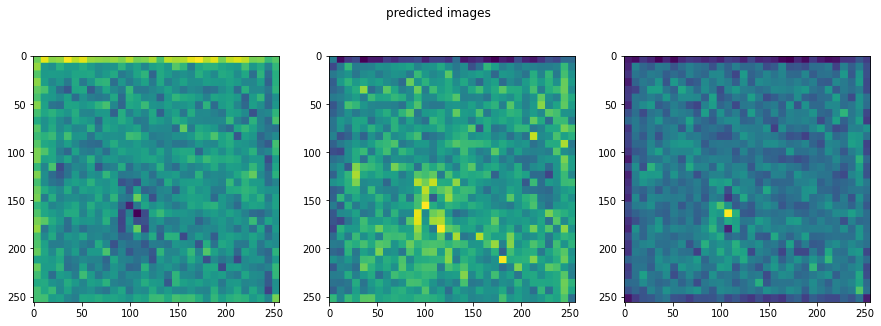

In [28]:
plt.imshow(test_x[12][:,:,0])
plt.show()

fig = plt.figure(figsize=(15,5))
fig.suptitle('test images')
fig.add_subplot(1,3,1)
plt.imshow(test_y[12][:,:,0])
fig.add_subplot(1,3,2)
plt.imshow(test_y[12][:,:,1])
fig.add_subplot(1,3,3)
plt.imshow(test_y[12][:,:,2])
plt.show()

t = myCNN.predict(test_x[12:13])[0]

fig = plt.figure(figsize=(15,5))
fig.suptitle('predicted images')
fig.add_subplot(1,3,1)
plt.imshow(t[:,:,0])
fig.add_subplot(1,3,2)
plt.imshow(t[:,:,1])
fig.add_subplot(1,3,3)
plt.imshow(t[:,:,2])
plt.show()

**Performance evaluation**

In [29]:
train_y_pred = myCNN.predict(train_x)
val_y_pred = myCNN.predict(val_x)
test_y_pred = myCNN.predict(test_x)

print('Train predictions shape: ',train_y_pred.shape)
print('Validation predictions shape: ',val_y_pred.shape)
print('Test predictions shape: ',test_y_pred.shape)

Train predictions shape:  (1462, 256, 256, 3)
Validation predictions shape:  (488, 256, 256, 3)
Test predictions shape:  (651, 256, 256, 3)


In [33]:
def prediction_check(groundtruth, predicted):
  true_pos = 0
  false_pos = 0
  false_neg = 0

  for predicted_source in predicted:
    true_source = False 
    for source in groundtruth:
      if abs(source[0]-predicted_source[0]) <=3 or abs(source[1]-predicted_source[1]) <=3:
        true_source = True
      
    if true_source:
      true_pos += 1
    else:
      false_pos += 1

  for source in groundtruth:
    found = False
    for predicted_source in predicted:
      if abs(source[0]-predicted_source[0]) <=3 or abs(source[1]-predicted_source[1]) <=3:
        found = True
    
    if not found:
      false_neg += 1

  return true_pos, false_pos, false_neg

In [34]:
def compute_results(groundtruth, predicted, threshold):
  
  true_pos = 0
  false_neg = 0
  false_pos = 0

  for i in range(len(predicted)):
    t = predicted[i].copy()
    t = t[:,:,0]

    t[t<threshold] = 0
    t[t>=threshold] = 1

    sources = np.flip(np.column_stack(np.where(groundtruth[i] > 0)),axis=1)
    predicted_sources = np.flip(np.column_stack(np.where(t > 0)),axis=1)
    true_pos_val, false_pos_val, false_neg_val = prediction_check(sources, predicted_sources)
    true_pos += true_pos_val
    false_pos += false_pos_val
    false_neg += false_neg_val

  recall = true_pos / (true_pos+false_neg)
  precision = true_pos / (true_pos+false_pos)
  f1 = (2 * precision * recall) / (precision + recall)

  print("True positives = {:d}".format(true_pos))
  print("False negatives = {:d}".format(false_neg))
  print("False positives = {:d}".format(false_pos))
  print("Set Recall = {:f}".format(recall))
  print("Set Precision = {:f}".format(precision))
  print("F1 Score = {:f}".format(f1))

In [35]:
print("Training set results:")
compute_results(train_y, train_y_pred, 0.04)

print("\n\nValidation set results:")
compute_results(val_y, val_y_pred, 0.04)

print("\n\nTest set results:")
compute_results(test_y, test_y_pred, 0.04)

Training set results:
True positives = 1876066
False negatives = 0
False positives = 93937566
Set Recall = 1.000000
Set Precision = 0.019580
F1 Score = 0.038409


Validation set results:
True positives = 628474
False negatives = 0
False positives = 31353094
Set Recall = 1.000000
Set Precision = 0.019651
F1 Score = 0.038545


Test set results:
True positives = 994728
False negatives = 0
False positives = 41669208
Set Recall = 1.000000
Set Precision = 0.023315
F1 Score = 0.045568
